In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_tokenizer = AutoTokenizer.from_pretrained(
    "/home/chengzhang/models/llama-hf/llama-7b_hf",
    local_files_only=False,
    trust_remote_code=True,
)
# add Flamingo special tokens to the tokenizer
text_tokenizer.add_special_tokens(
    {"additional_special_tokens": ["<|endofchunk|>", "<image>"]}
)
if text_tokenizer.pad_token is None:
    # Issue: GPT models don't have a pad token, which we use to
    # modify labels for the loss.
    text_tokenizer.add_special_tokens({"pad_token": "<PAD>"})

lang_encoder = AutoModelForCausalLM.from_pretrained(
    "/home/chengzhang/models/llama-hf/llama-7b_hf",
    local_files_only=False,
    trust_remote_code=True,
)

Using pad_token, but it is not set yet.


[2023-10-11 02:50:48,495] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


In [3]:
lang_encoder = lang_encoder.cuda()

In [4]:
linear_modules: dict[str, torch.nn.Module] = {}

for i, layer in enumerate(lang_encoder.model.layers):
    for x in ['q', 'k', 'v', 'o']:
        proj_id = f'llama/{i}-self-{x}-proj'
        linear_modules[proj_id] = getattr(layer.self_attn, f'{x}_proj')
    for x in ['gate', 'down', 'up']:
        proj_id = f'llama/{i}-self-{x}-proj'
        linear_modules[proj_id] = getattr(layer.mlp, f'{x}_proj')

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(lang_encoder.model.layers):
    ln_modules[f'llama/{i}-self-input-ln'] = layer.input_layernorm
    ln_modules[f'llama/{i}-self-post-attn-ln'] = layer.post_attention_layernorm

for name, module in ln_modules.items():
    module.unique_name = name

In [5]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/open_flamingo/snapshot'

In [6]:
def save_activations(hooks):

    for i in range(10):

        q = questions[i]
        question = q['question']
        question_id = q['question_id']

        lang_x = text_tokenizer([question], return_tensors="pt")

        act_folder = f'{SNAPSHOT_PATH}/activations-text/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/perceiver', exist_ok=True)
        os.makedirs(f'{act_folder}/llama', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        def hook(m, input, output):
            torch.save(input, f'{act_folder}/{m.unique_name}.pt')

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        lang_encoder(lang_x["input_ids"].cuda(), lang_x["attention_mask"].cuda())

# save_activations(hooks)

In [7]:
def load_act(path: str, comp: str) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(10):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        acts.append(act.abs().max(dim=0).values.detach())
        # acts.append(act.abs().sum(dim=0).detach())
        tokens += act.shape[0]
    return torch.stack(acts).max(dim=0).values.cpu().numpy()
    # return (torch.stack(acts).sum(dim=0) / tokens).cpu().numpy()

In [17]:
layer = 15
comp = 'self-up-proj'
mm_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}')
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-{comp}')
channels = mm_per_channel.shape[-1]

In [18]:
outliers = channels // 100
mm_outliers = mm_per_channel.argsort()[-outliers:]
text_outliers = text_per_channel.argsort()[-outliers:]
old_outliers = set(text_outliers) - set(mm_outliers)
new_outliers = set(mm_outliers) - set(text_outliers)
print(len(new_outliers))

mm_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
text_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
for idx in mm_outliers:
    mm_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
for idx in text_outliers:
    text_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
for idx in new_outliers:
    mm_colors[idx] = np.array([0xff, 0x7f, 0x0e]) / 255
for idx in old_outliers:
    text_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255

9


3968 6.406
3968 6.4080834


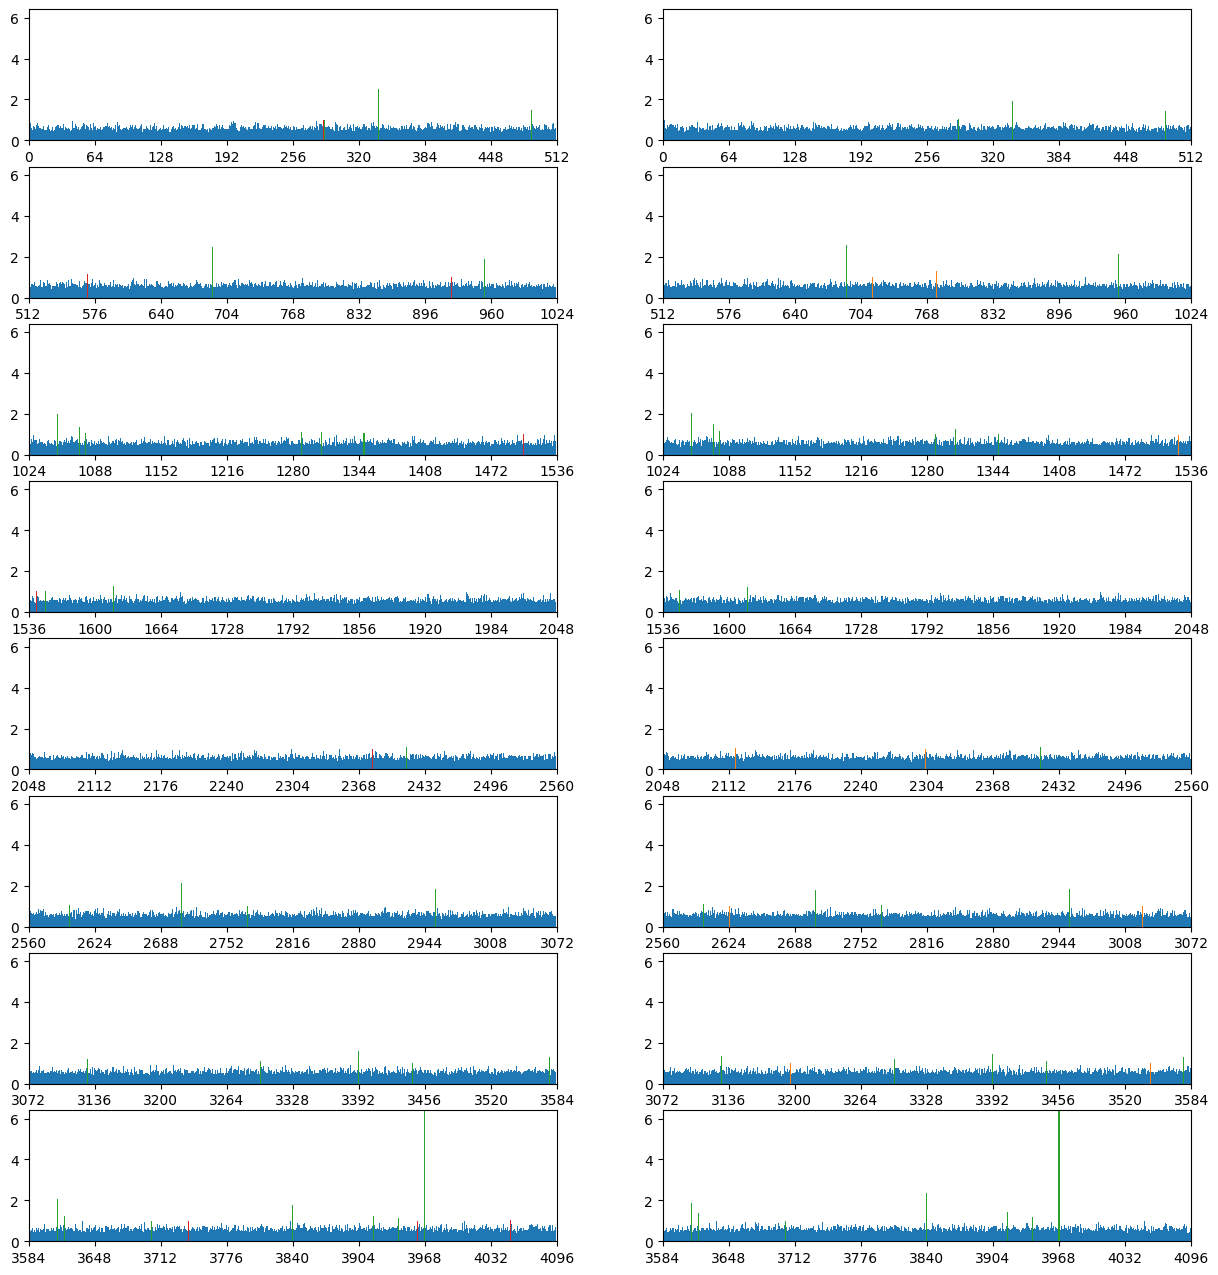

In [19]:
max_val = max(mm_per_channel.max(), text_per_channel.max())

print(mm_per_channel.argmax(), mm_per_channel.max())
print(text_per_channel.argmax(), text_per_channel.max())

groups = (channels + 512 - 1) // 512

plt.figure(figsize=(15, 2 * groups))

def plot_group(tensor, colors, start, stop, idx):
    ax = plt.subplot(groups, 2, idx)
    ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
    # ax.set_ylim(0, np.ceil(max_val))
    ax.set_ylim(0, max_val)
    ax.set_xlim(start, start + 512)
    ax.set_xticks(np.arange(start, start + 513, 64))

for group_id in range(groups):
    ax = plt.subplot(groups, 2, group_id * 2 + 1)
    start = group_id * 512
    stop = min(start + 512, channels)
    plot_group(text_per_channel, text_colors, start, stop, group_id * 2 + 1)
    plot_group(mm_per_channel, mm_colors, start, stop, group_id * 2 + 2)